## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
%matplotlib inline

In [2]:
def calibration(images, show_images=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
#     images = glob.glob('../camera_cal/calibration*.jpg')
    for image in images:
       # Step through the list and search for chessboard corners
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        #If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            if show_images == True:
                img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # in order to plot using matplotlib(RGB)
                plt.figure()
                plt.imshow(img)
                plt.show()
    ret, C_mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return objpoints, imgpoints, C_mtx, dist_coef

In [3]:
def undistorted(img, C_mtx, coef):
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, C_mtx, coef, None, C_mtx)
    return img, undist

def plot_compare(inputs, name='', figure_size = (20,10)):
    if len(inputs)==1:
        plt.figure(figsize=figure_size)
        plt.imshow(inputs[0], cmap='gray')
        plt.title(name, fontsize=30)
        return 
    n = len(inputs)
    f, axs = plt.subplots(1,n,figsize=figure_size)
    for i in range(n):
        if len(inputs[i].shape) < 3:
            axs[i].imshow(inputs[i], cmap='gray')
            if len(name) == 3:
                axs[i].set_title(name[i-1], fontsize=25)
            elif name == 'YCrCb':
                title = ['Y', 'Cr', 'Cb']
                axs[i].set_title(title[i-1], fontsize=25)
            else:
                axs[i].set_title('Binary', fontsize=25)
        elif i == 0:
            img_ = cv2.cvtColor(inputs[i],cv2.COLOR_BGR2RGB)
            axs[i].imshow(img_)
            if name:
                axs[i].set_title(name, fontsize=25)
            else:
                axs[i].set_title('Original image', fontsize=25)
        else:
            img_ = cv2.cvtColor(inputs[i],cv2.COLOR_BGR2RGB)
            axs[i].imshow(img_)
#             axs[i].set_title('Undistorted image', fontsize=25)
            axs[i].set_title('Modified image', fontsize=25)
 
    return 

In [4]:
# Make a list of calibration images 
images = glob.glob('camera_cal/calibration*.jpg') 
# Camera calibration 
obj_points, img_points, C_mtx, dist_coef = calibration(images)


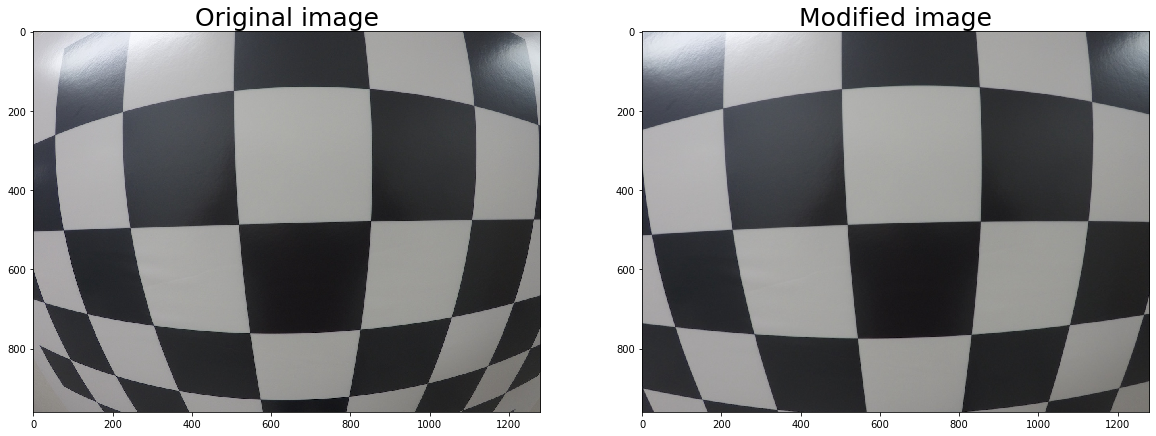

In [5]:
# show the undistorted result of calibration image
idx = 5
target = 'camera_cal/calibration'+str(idx)+'.jpg'
output_path = 'output_images/undistorted'+str(idx)+'.png'

test = 'camera_cal/test_image.jpg'
target_img = cv2.imread(test)
img_, undist_ = undistorted(target_img, C_mtx, dist_coef)
# cv2.imwrite(output_path, undist_)

plot_compare([img_, undist_])

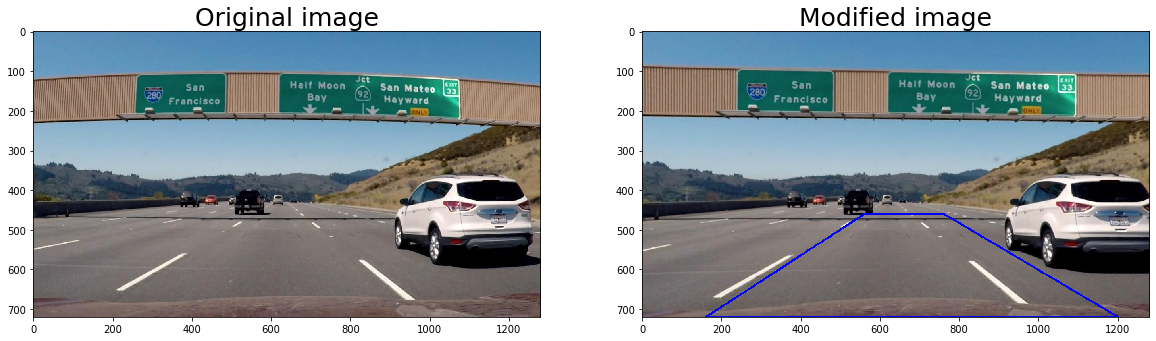

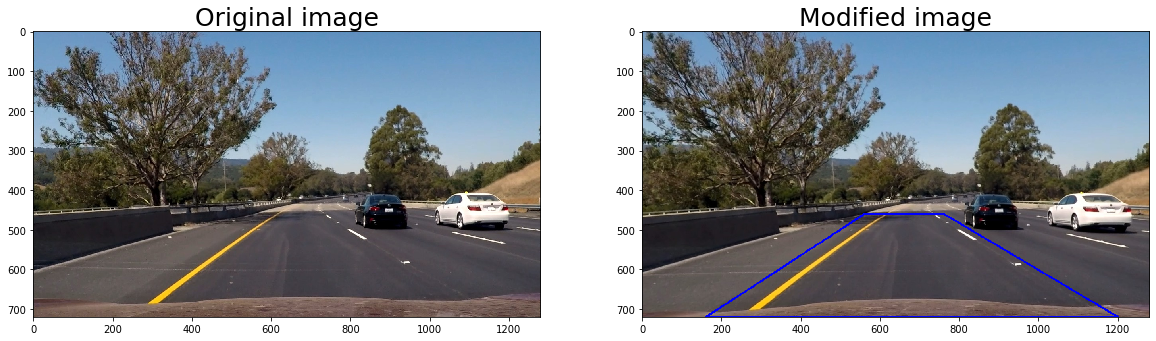

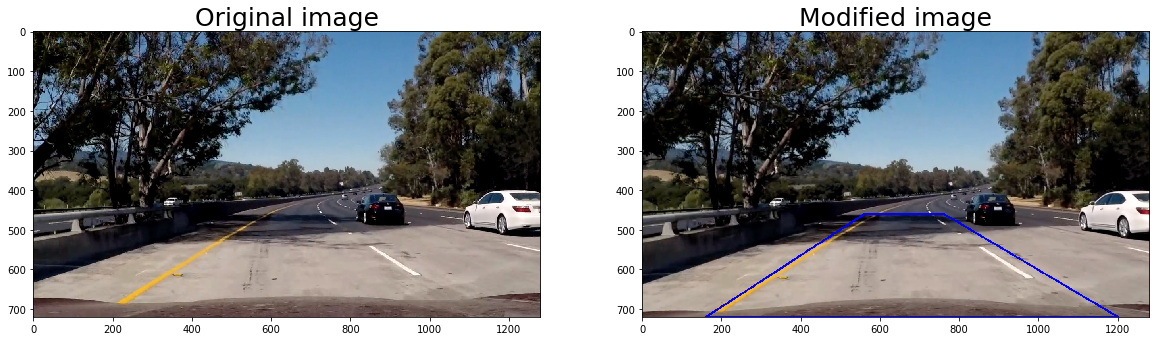

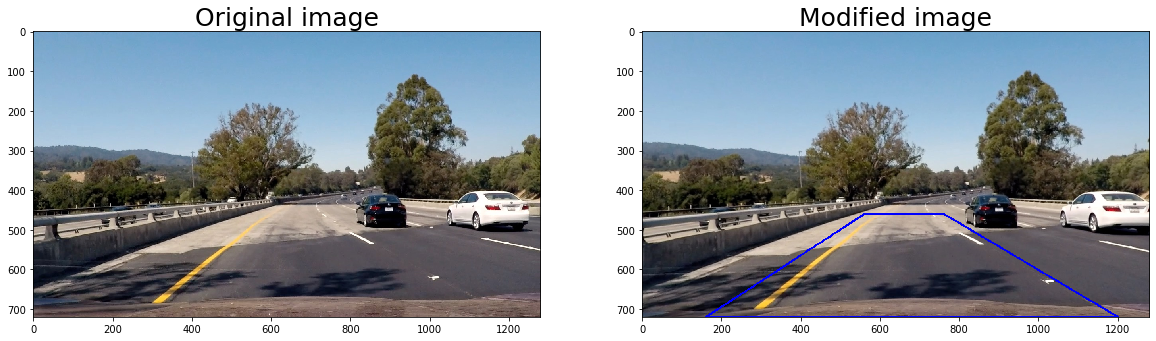

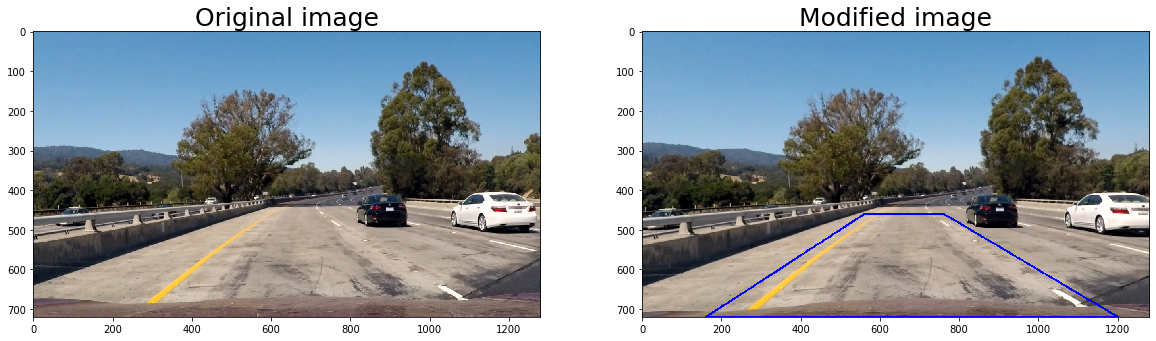

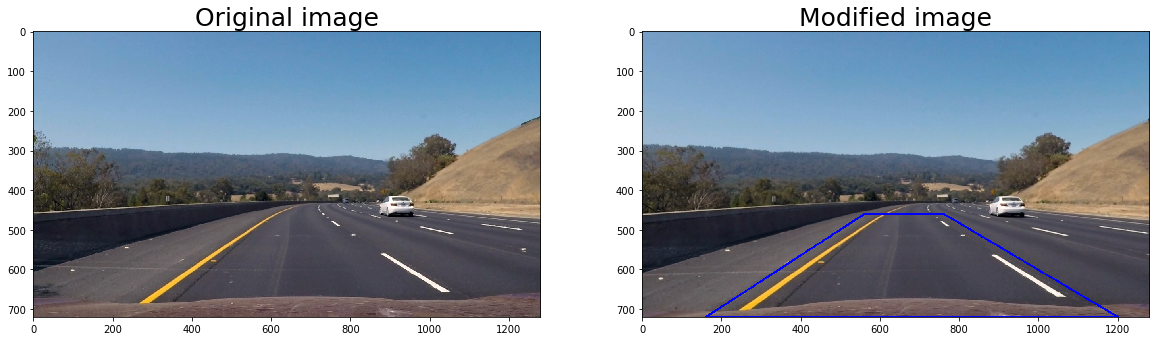

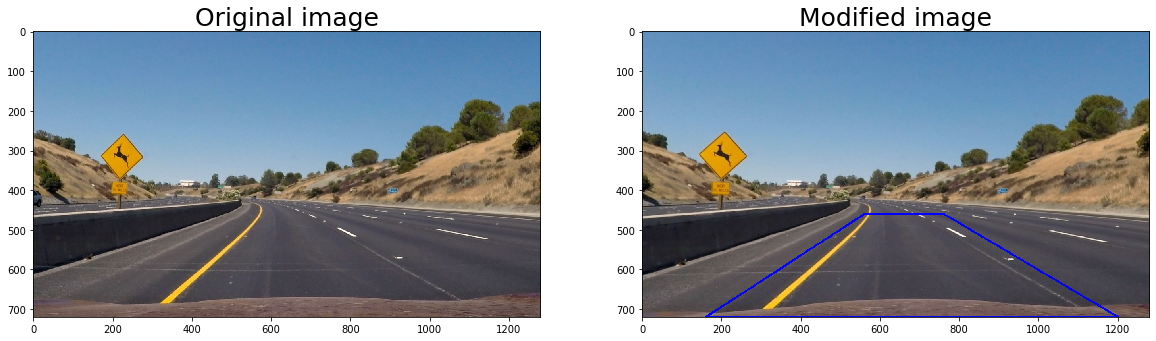

In [6]:
def draw_ROI(image, nodes):
    copy_img = np.copy(image) 
    thickness = 3
    color = (255, 0,0) # blue
    is_closed = True
    vertices = nodes.reshape(-1,1,2)
    return cv2.polylines(copy_img, [vertices], is_closed, color, thickness)

test_all = 'test_images/test*.jpg'

# define region of interest
top = 460 
bot = 720
lt, lb = 560, 160
rt, rb = 760, 1200
nodes = np.array([[lt, top], [rt, top], [rb, bot], [lb, bot]], np.int32)

tests = glob.glob(test_all)
kernel_size = 3

i = 1
for test in tests:
    # camera calibration + undistorted  
    test_img = cv2.imread(test)
    img, undist = undistorted(test_img, C_mtx, dist_coef)
    ROI = draw_ROI(undist, nodes)
    plot_compare([img, ROI])
#     cv2.imwrite('output_images/test_roi'+str(i)+'.png', ROI)
#     cv2.imwrite('output_images/test_un'+str(i)+'.jpg', undist)
    i+=1

In [7]:
# gradient thresholding
def thresholding(channel, threshold):
    binary = np.zeros_like(channel)
    binary[(channel > threshold[0]) & (channel <= threshold[1])] = 1
    return binary

def sobel_magnitude(gray, mag_thresh=(0,255),sobel_kernel=5):
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag = np.sqrt(sx*sx+sy*sy)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    
    return thresholding(scaled_mag, mag_thresh)


def sobel_direction(gray, dir_thresh=(0,np.pi/2), sobel_kernel=5):
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    phi = np.arctan2(np.absolute(sy), np.absolute(sx))
    
    return thresholding(phi, dir_thresh)


def sobel_xy(gray, coordinate, threshold=(0,255), sobel_kernel=5):
    if coordinate == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif coordinate == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        
    return thresholding(scaled_sobel, threshold) 

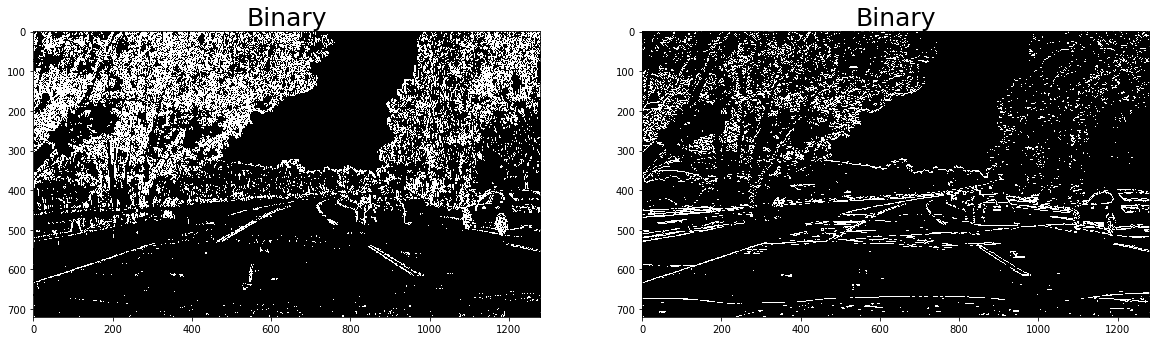

In [8]:
# apply Sobel operator 
# straight_lines1
test_path = 'test_images/test5.jpg'
binary1 = 'output_images/xy.png'
bina = 'output_images/all.png'
bina3 = 'output_images/mag_ori.png'
imgg = cv2.imread(test_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
b1 = sobel_magnitude(gray, (50,200), sobel_kernel = kernel_size)
b2 = sobel_direction(gray, (0.7,1.3), sobel_kernel = kernel_size)
b3 = sobel_xy(gray, 'x', (10,160), sobel_kernel = kernel_size)
b4 = sobel_xy(gray, 'y', (25,150), sobel_kernel = kernel_size)

sobel_combined = np.zeros_like(b1)
sobel_combined[((b3==1) & (b4==1)) | ((b1==1) & (b2==1))] = 1
sobel_combined2 = np.zeros_like(b1)
sobel_combined2[(b3==1) & (b4==1)] = 1
sobel_combined3 = np.zeros_like(b1)
sobel_combined3[(b1==1) & (b2==1)] = 1
# plt.imsave(binary1, sobel_combined2, cmap='gray') # cv2.imwrite(binary1, binary)
# plt.imsave(bina, sobel_combined, cmap='gray')
# plt.imsave(bina3, sobel_combined3, cmap='gray')
# plot_compare([imgg, sobel_combined, sobel_combined2])
plot_compare([b3,b4])

# plt.imsave('../output_images/sobel_x.png', b3, cmap='gray')
# plt.imsave('../output_images/sobel_y.png', b4, cmap='gray')
# plt.imsave('../output_images/sobel_mag.png', b1, cmap='gray')
# plt.imsave('../output_images/sobel_dir.png', b2, cmap='gray')

In [9]:
#color spaces: 'RGB', 'HSV', 'HLS', 'Lab', 'Luv', 'YUV', 'YCrCb' 
def color_thresholding(img, type_, threshold, show=False):
    if type_ == 'RGB':
        R_ch = img[:,:,2]
        G_ch = img[:,:,1]
        B_ch = img[:,:,0]
        # RGB thresholding works best on white lane pixels
        binary_R = thresholding(R_ch, threshold)
        binary_G = thresholding(G_ch, threshold)
        binary_B = thresholding(B_ch, threshold)
        ans = [binary_R, binary_G, binary_B]
        if show:
            ex = np.hstack((binary_R, binary_G, binary_B))
            plot_compare([ex], type_)
    elif type_ == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binary = thresholding(gray, threshold)
        if show:
            plot_compare([binary], type_+'scale')
        ans = [binary]
    elif type_ == 'HLS':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        H_ch = hls[:,:,0]
        L_ch = hls[:,:,1]
        S_ch = hls[:,:,2]
        binary_H = thresholding(H_ch, threshold)
        binary_L = thresholding(L_ch, threshold)
        binary_S = thresholding(S_ch, threshold)
        ans = [binary_H, binary_L, binary_S]
        if show:
            plot_compare([np.hstack((binary_H, binary_L, binary_S))], type_)
    elif type_ == 'HSV':
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H_ch = hsv[:,:,0]
        S_ch = hsv[:,:,1]
        V_ch = hsv[:,:,2]
        binary_H = thresholding(H_ch, threshold)
        binary_S = thresholding(S_ch, threshold)
        binary_V = thresholding(V_ch, threshold)
        ans = [binary_H, binary_S, binary_V]
        if show:
            plot_compare([np.hstack((binary_H, binary_S, binary_V))], type_)
    elif type_ == 'Lab':
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        L_ch = lab[:,:,0]
        a_ch = lab[:,:,1]
        b_ch = lab[:,:,2]
        binary_L = thresholding(L_ch, threshold)
        binary_a = thresholding(a_ch, threshold)
        binary_b = thresholding(b_ch, threshold)
        ans = [binary_L, binary_a, binary_b]
        if show:
            plot_compare([np.hstack((binary_L, binary_a, binary_b))], type_)
    elif type_ == 'Luv':
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
        L_ch = luv[:,:,0]
        u_ch = luv[:,:,1]
        v_ch = luv[:,:,2]
        binary_L = thresholding(L_ch, threshold)
        binary_u = thresholding(u_ch, threshold)
        binary_v = thresholding(v_ch, threshold)
        ans = [binary_L, binary_u, binary_v]
        if show:
            plot_compare([np.hstack((binary_L, binary_u, binary_v))], type_)
    elif type_ == 'YUV':
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        Y_ch = yuv[:,:,0]
        U_ch = yuv[:,:,1]
        V_ch = yuv[:,:,2]
        binary_Y = thresholding(Y_ch, threshold)
        binary_U = thresholding(U_ch, threshold)
        binary_V = thresholding(V_ch, threshold)
        ans = [binary_Y, binary_U, binary_V]
        if show:
            plot_compare([np.hstack((binary_Y, binary_U, binary_V))], type_)
    elif type_ == 'YCrCb':
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y_ch = ycrcb[:,:,0]
        cr_ch = ycrcb[:,:,1]
        cb_ch = ycrcb[:,:,2]
        binary_y = thresholding(y_ch, threshold)
        binary_cr = thresholding(cr_ch, threshold)
        binary_cb = thresholding(cb_ch, threshold)
        ans = [binary_y, binary_cr, binary_cb]
        if show:
            plot_compare([np.hstack((binary_y, binary_cr, binary_cb))], type_)
    return ans
        

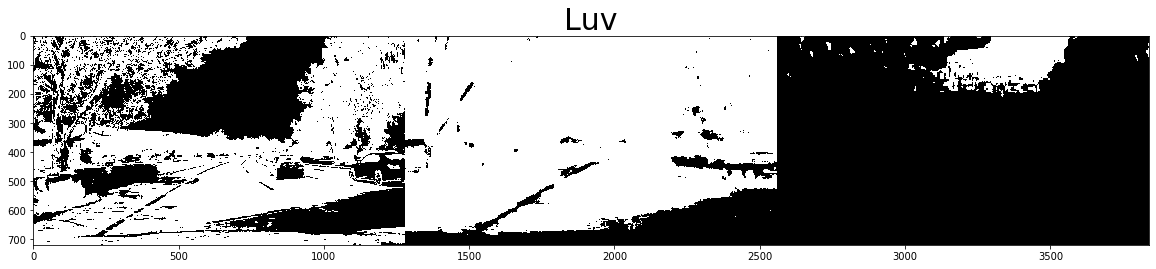

In [203]:
# get binary from color space transform
color_spaces = ['RGB','gray','HSV', 'HLS', 'Lab', 'Luv', 'YUV', 'YCrCb']
cha = 'test_images/challenge1.jpg'
test_path = 'test_images/color_check2.jpg'
# test_path = 'test_images/test5.jpg'
temp = cv2.imread(test_path)
threshold = (170,255)
# plt.imshow(cv2.cvtColor(temp, cv2.COLOR_RGB2BGR))
# chs = color_thresholding(temp, 'Lab', (160,220), True)
chs = color_thresholding(temp, 'Luv', (0, 100), True)
# for space in color_spaces:
#     chs = color_thresholding(temp, space, threshold, True)
#     plt.imsave('../output_images/color_'+space+'1.png', chs[0], cmap='gray')
#     plt.imsave('../output_images/color_'+space+'2.png', chs[1], cmap='gray')
#     plt.imsave('../output_images/color_'+space+'3.png', chs[2], cmap='gray')


In [11]:
# from normal view to bird's eye(top-down) view
def perspective_transform(undist, src, dst, nx=9,ny=6):
    if len(undist.shape) < 3:
        gray = np.copy(undist)
    else:
        gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # create warped image using linear interpolation
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

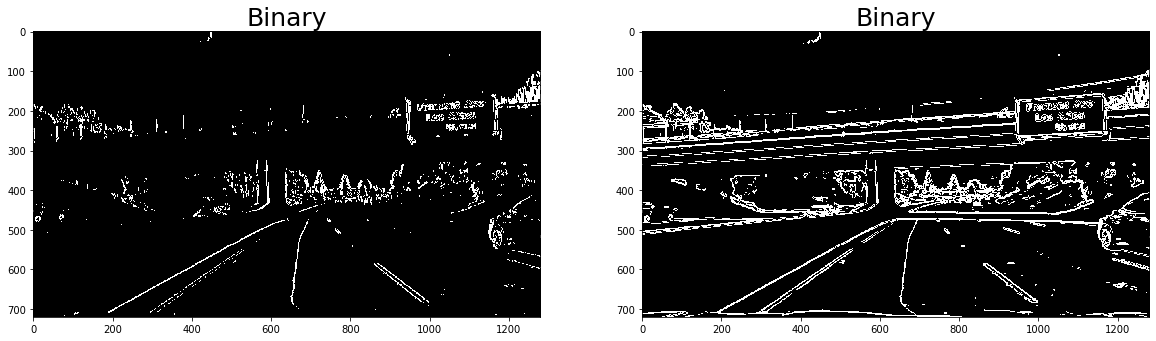

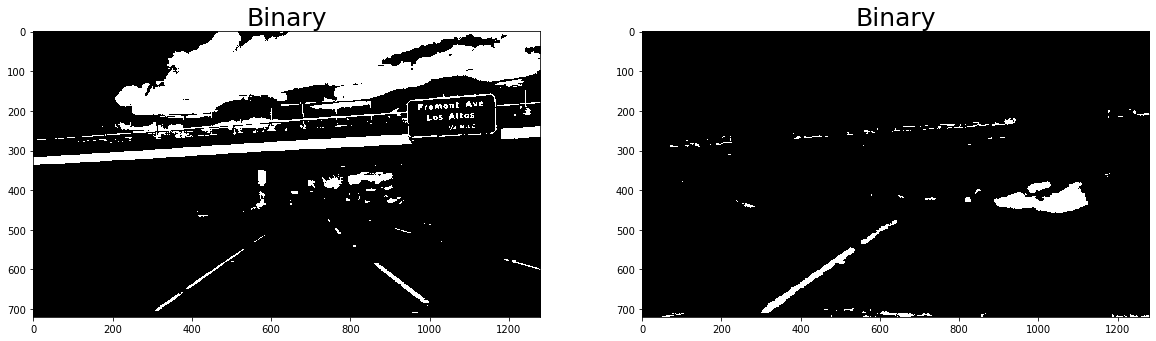

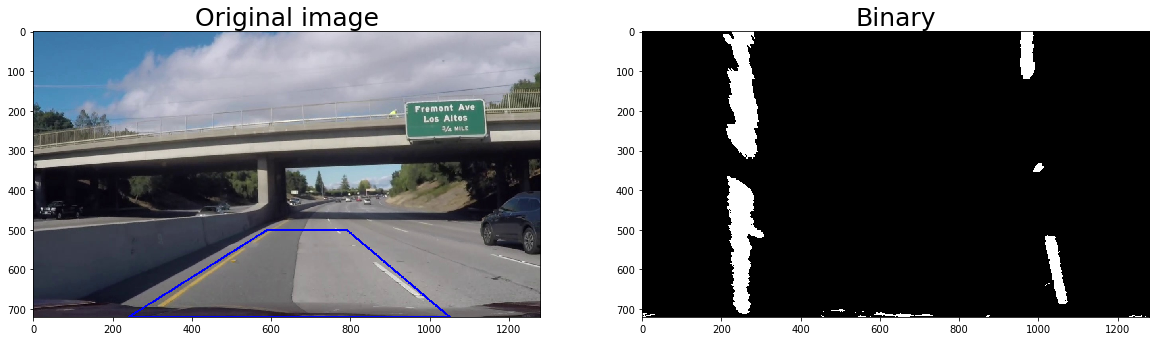

In [12]:
def testing1(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = image.shape
    offset = 200
    # define the source and destination points for perspective transform
    top, bot = 500, 720
    lt, lb = 590, 240
    rt, rb = 790, 1050
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[lb, 0],[rb,0],[rb,bot],[lb,bot]])
    dst1 = np.float32([[offset, 0], [image_size[1]-offset, 0], [image_size[1]-offset, image_size[0]], [offset, image_size[0]]])

    img4, undist4 = undistorted(image, C_mtx, dist_coef)
    # color and gradient thresholding
    color_threshold = (170,255)
    channels = color_thresholding(undist4, 'RGB', color_threshold)
    channels2 = color_thresholding(undist4, 'Luv', (100,160))
    ch = channels[0] # single channel 
    ch2 = channels2[1]
    
    gray4 = cv2.cvtColor(undist4, cv2.COLOR_BGR2GRAY)
    sobel_threshold = (20,100)
    threshold_y = (100,200)
    dir_threshold = (0.7, 1.3)
    sobel_m = sobel_magnitude(gray4, sobel_threshold)
    sobel_d = sobel_direction(gray4, dir_threshold)
    sobel = sobel_xy(gray4, 'x', sobel_threshold) # use x direction is better since the lane lines are usually vertical
    sobely = sobel_xy(gray4, 'y', threshold_y)

    combined5 = np.zeros_like(sobel)
    combined5[((sobel_m==1)&(sobel_d==1))|(sobel==1)] = 1
    combined_final = np.zeros_like(ch)
    combined_final[((ch==1)|(ch2==1))] = 1
#     combined_final[((ch==1))|(sobel==1)] = 1
    combined6 = np.zeros_like(sobel)
    combined6[((ch==1))|((sobel_m==1)&(sobel_d==1))|(sobel==1)] = 1

    top_down, per_M, Minv = perspective_transform(combined_final, src, dst1)
    ROI = draw_ROI(img4, np.array([[lt, top], [rt, top], [rb, bot], [lb, bot]], np.int32))
    ROI_ = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
    
    plot_compare([sobel, sobel_m])
    plot_compare([ch, ch2])
    # plot_compare([combined5, combined_final])
    plot_compare([ROI, top_down])
    # plt.imsave('output_images/pers1.png', ROI_)
    # plt.imsave('output_images/pers2.png', top_down, cmap='gray')
    return top_down

# perform perspective transform
challenge = 'test_images/challenge3.jpg' 
path = 'test_images/test4.jpg'
tp = 'test_images/color_check2.jpg'

image = cv2.imread(tp)
top_down = testing1(image)
# plt.figure()
# plt.imshow(top_down)

In [204]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
class Line():
    mp_y = 30/720 # meter per pixel
    mp_x = 3.7/700 # meter per pixel
    
    def __init__(self, size = 9):
        self.buffer_size = size
        # was the line detected in the last iteration?
        self.detected = False  

        self.current_fitx = None
        self.recent_fitx = collections.deque([], maxlen=self.buffer_size) 
        self.current_fit = np.ndarray([])
        self.recent_fit = collections.deque([], maxlen=self.buffer_size)   
        self.yp = None
        self.bestx = None     
        self.best_fit = None 
        self.radius_of_curvature = None 
        self.check = True
        self.no_detect_count = 0

In [205]:
def histogram(binary, size):
    histogram = np.sum(binary[size[0]//2:,:], axis=0) # 1/3 of the height from bottom
    indices = find_peaks_cwt(histogram, np.arange(1,150), min_length=150)
    
    if len(indices) > 1:
        left_peak, *_, right_peak = indices
    else:
        midpoint = np.int(histogram.shape[0]//2)
        left_peak = np.argmax(histogram[:midpoint])
        right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_peak, right_peak

def poly_fitting(x_indices, y_indices):
    return np.polyfit(y_indices, x_indices, 2)

def big_window(size, lane, nonzerox, nonzeroy):
    good_indices = []
    c2 = 20 # small offset
    win_y_low = 0
    win_y_high = size[0]-30
    if lane=="left":
        win_xleft_low = 0+c2
        win_xleft_high = size[1]//2-c2
        good_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    elif lane == "right":
        win_xright_low = size[1]//2+c2
        win_xright_high = size[1]-c2
        good_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    return good_indices

def sliding_window(warped_binary, visual=False, nwindows = 10):
    global ll, rl
    # detect lane pixels and fit to find the lane boundary
    size_ = warped_binary.shape
    
    # Current positions to be updated later for each window in nwindows
    leftx_current, rightx_current = histogram(warped_binary, size_)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    
    min_pix = 45 # Set minimum number of pixels found to recenter window
    margin = 90 # Set the width of the windows +/- margin
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(size_[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for w in range(nwindows):
        # find out the boundaries of each window
        win_y_low = size_[0] - (w+1)*window_height
        win_y_high = size_[0] - w*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw rectangles 
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # identify the nonzero pixels in x and y within the window, nonzero() returns indices of non-zero elements
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        if good_left_inds.size == 0:
#             print('left window nope')
            ll.no_detect_count+=1
        if good_right_inds.size == 0:
#             print('right window nope')
            rl.no_detect_count+=1
        # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # if you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    
    min_bad_window = 4  # the minimum number of accepted no-detection windows
    if ll.no_detect_count > min_bad_window:
        print('left window stacking')
        ll.no_detect_count = 0 
        left_lane_inds = big_window(size_, "left", nonzerox, nonzeroy)
        
    if rl.no_detect_count > min_bad_window:
        print('right window stacking')
        rl.no_detect_count = 0 
        right_lane_inds = big_window(size_, "right", nonzerox, nonzeroy)
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    if len(leftx) == 0 and len(lefty) == 0:
        print('no left detection')
        print(len(ll.recent_fit), len(rl.recent_fit))
        left_fit = ll.recent_fit[-1]
    else:
        left_fit = poly_fitting(leftx, lefty)
    if len(rightx) == 0 and len(righty) == 0:
        print('no right detection')
        right_fit = rl.recent_fit[-1]
    else:
        right_fit = poly_fitting(rightx, righty)

    # Generate x and y values for plotting
    ploty = np.linspace(0, size_[0]-1, size_[0])
    ll.yp = ploty
    rl.yp = ploty
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ll.detected = True
    ll.current_fit = left_fit
    ll.current_fitx = left_fitx
    rl.detected = True
    rl.current_fit = right_fit
    rl.current_fitx = right_fitx
    
    # check the result, add to the buffer and get the average.
    ring_buffer()

    if(visual):
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        poly_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
        cv2.polylines(out_img, [poly_left], False, (255,255,0), 2) 
        poly_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
        cv2.polylines(out_img, [poly_right], False, (255,255,0), 2) 
    
    return out_img

def search_around_previous(binary_warped, visual = False):
    global ll, rl
    # HYPERPARAMETER
    margin = 65 # searching region
    
    size_ = binary_warped.shape
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # find out the points that are inside the margin using previous points(current_fit)
    left_lane_inds = ((nonzerox > (ll.current_fit[0]*(nonzeroy**2) + ll.current_fit[1]*nonzeroy + 
                    ll.current_fit[2] - margin)) & (nonzerox < (ll.current_fit[0]*(nonzeroy**2) + 
                    ll.current_fit[1]*nonzeroy + ll.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (rl.current_fit[0]*(nonzeroy**2) + rl.current_fit[1]*nonzeroy + 
                    rl.current_fit[2] - margin)) & (nonzerox < (rl.current_fit[0]*(nonzeroy**2) + 
                    rl.current_fit[1]*nonzeroy + rl.current_fit[2] + margin)))
    
#     if left_lane_inds.size == 0 or right_lane_inds.size == 0:
#         return None
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (leftx.size == 0 and lefty.size == 0) or (rightx.size == 0 and righty.size == 0):
        print('Warning!')
        return None

    # Fit new polynomials
    left_fit = poly_fitting(leftx, lefty)
    right_fit = poly_fitting(rightx, righty)
    
     # Generate x and y values for plotting
    ploty = np.linspace(0, size_[0]-1, size_[0])
    ll.yp = ploty
    rl.yp = ploty

    ll.current_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rl.current_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ll.current_fit = left_fit
    rl.current_fit = right_fit
    
    # check the result, add to the buffer and get the average.
    check = ring_buffer()
    if check == "BAD":
        return None
    
    ## Visualization ##
    if visual:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([ll.current_fitx-margin, ll.yp]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([ll.current_fitx+margin, ll.yp])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([rl.current_fitx-margin, rl.yp]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rl.current_fitx+margin, rl.yp])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
#         poly_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
#         cv2.polylines(out_img, [poly_left], False, (255,255,0), 2) 
#         poly_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
#         cv2.polylines(out_img, [poly_right], False, (255,255,0), 2) 
    
    return result

In [206]:
# calculation curvature( of polynomial function in pixels)
def curvature(ploty, left_fit, right_fit):
    global ll
    y_eval = np.max(ploty)*ll.mp_y
    A1 = left_fit[0]*ll.mp_x/(ll.mp_y*ll.mp_y)
    B1 = left_fit[1]*ll.mp_x/ll.mp_y
    A2 = right_fit[0]*ll.mp_x/(ll.mp_y*ll.mp_y)
    B2 = right_fit[1]*ll.mp_x/ll.mp_y
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*A1*y_eval + B1)**2)**1.5) / np.absolute(2*A1)
    right_curverad = ((1 + (2*A2*y_eval + B2)**2)**1.5) / np.absolute(2*A2)
    
    return left_curverad, right_curverad

def get_offset(img_size):
    global rl, ll
    camera_mid = img_size[1]//2
    # center position of the car away from the center of lane
    lane_mid = (ll.current_fitx[-1]+rl.current_fitx[-1])/2
    
    offset = (lane_mid - camera_mid)*ll.mp_x # in meter
    offset = int(offset*1000)/1000
    return offset

def visualize(img_size, topdown, undist, offset, fit_result, Minv):
    # Create an image to draw the lines on
    global rl, ll
    warp_zero = np.zeros_like(topdown).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([ll.bestx, ll.yp]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rl.bestx, rl.yp])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (img_size[1], img_size[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)
    
    text_xmin = 30
    font_scale = 1.1
    cv2.putText(result, '{}  Right lane curvature : {}m'.format(str(rl.check), int(rl.radius_of_curvature)), (text_xmin,90), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    cv2.putText(result, '{}  Left lane curvature : {}m'.format(str(ll.check), int(ll.radius_of_curvature)), (text_xmin,135), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    if offset > 0: 
        # to the left
        cv2.putText(result, 'Car center: {} m to the left'.format(np.absolute(offset)), (text_xmin,45), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    else:
        # to the right
        cv2.putText(result, 'Car center: {} m to the right'.format(np.absolute(offset)), (text_xmin,45), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
        
    # this is used to display a subwindow for debugging
    bird_eye = True
    if bird_eye:
        sub_size = (580, 340)
        TopDown = cv2.resize(fit_result, sub_size)
        result[:sub_size[1],img_size[1]-sub_size[0]:] = TopDown
    
    return result

def sanity_check():
    # check if similar curvature, parallel, horizontal distance between lanes, 
    global rl, ll
    ll.check=True
    rl.check=True
    
    if len(ll.recent_fit) > 2:
        # really bad detection 
        dif_cur = rl.current_fitx-ll.current_fitx
        dif_min = np.amin(dif_cur)*ll.mp_x
#         dif_max = np.amax(dif_cur)*ll.mp_x
        # check lane width 3.7 m 
#         lane_width = 3.7
#         P = 0.25 # percentage
#         if dif_min < lane_width*(1-P) or dif_max > lane_width*(1+P):
        if dif_min < 2.5:
            ll.check = False
            rl.check = False
            print('BAD')
            return "BAD"
        factor = 5
        min_curv = 180 # 30 
        max_curv = 40000 
        left_cur_roc, right_cur_roc = curvature(ll.yp, ll.current_fit, rl.current_fit)
        if left_cur_roc > max_curv or left_cur_roc < min_curv: 
            ll.check = False
        if right_cur_roc > max_curv or right_cur_roc < min_curv:
            rl.check = False       
        
    return 


def ring_buffer(): 
    global rl, ll
    # if pass sanity check, add this detection, else discard it.
    result = sanity_check()
    if ll.check:
        ll.recent_fit.append(ll.current_fit)
        ll.recent_fitx.append(ll.current_fitx)
        n_ = len(ll.recent_fit)
        ll.best_fit = np.sum(ll.recent_fit, axis=0)/n_
        ll.bestx = np.sum(ll.recent_fitx, axis=0)/n_
        
    if rl.check:
        rl.recent_fit.append(rl.current_fit)
        rl.recent_fitx.append(rl.current_fitx)
        n_ = len(rl.recent_fit)
        rl.best_fit = np.sum(rl.recent_fit, axis=0)/n_
        rl.bestx = np.sum(rl.recent_fitx, axis=0)/n_
    return result


def lane_finding(top_down):
    global rl, ll
    if rl.detected == False and ll.detected == False:
#         print('Sliding window!')
        output = sliding_window(top_down, True) 
    else:
        # targeted search
        output = search_around_previous(top_down, True)
        if output is None:
            rl.detected = False
            ll.detected = False
            # sliding window
            output = sliding_window(top_down, True)
    return output


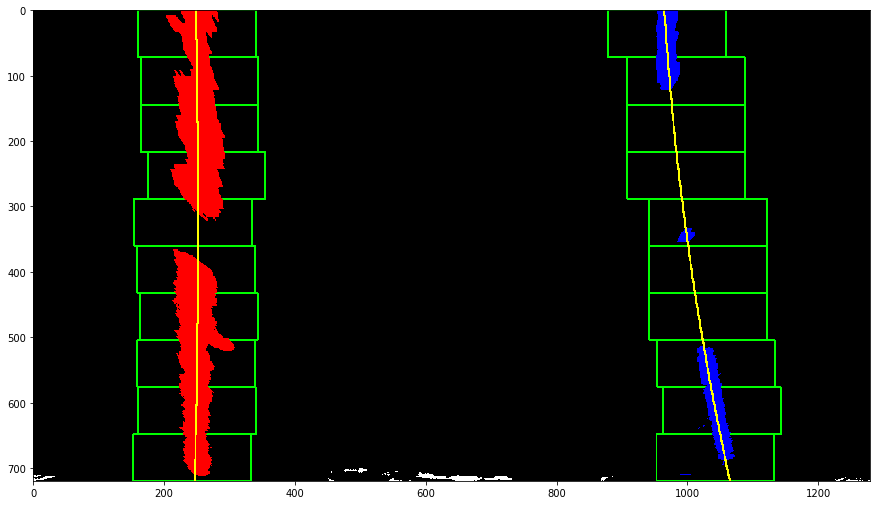

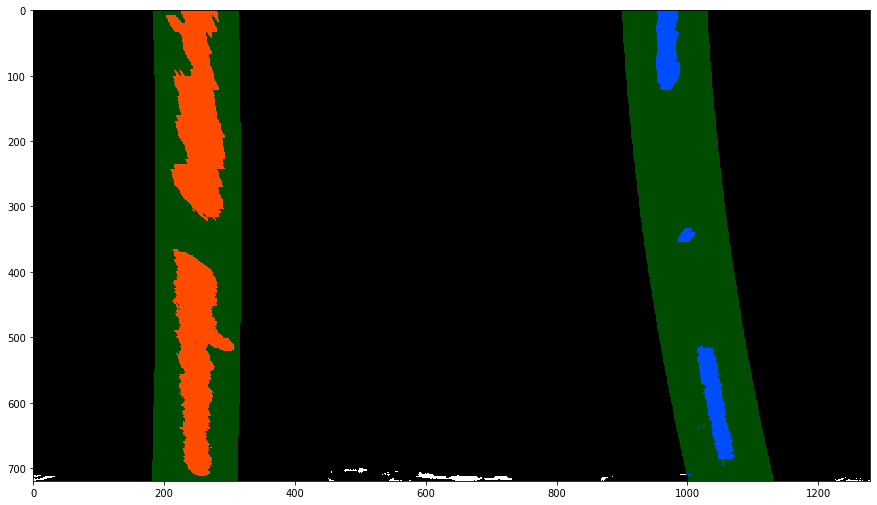

In [207]:
ll, rl = Line(), Line()
warped_binary = np.copy(top_down)
plt.figure(figsize = (15,10))
output = sliding_window(warped_binary, True)
plt.imshow(output)
# plt.imsave('output_images/windows.png', output, cmap='gray')

lc, rc = curvature(ll.yp, ll.best_fit, rl.best_fit)
# print(lc, rc)

output = search_around_previous(warped_binary, True)
# print(output)
plt.figure(figsize = (15,10))
plt.imshow(output)
# plt.imsave('output_images/targeted.png', output, cmap='gray')

In [210]:
def pipeline(origin_image):
    # get precalculated camera calibration factors
    global C_mtx ,dist_coef 
    global rl, ll
    
    # distortion correction
    origin, undist = undistorted(origin_image, C_mtx, dist_coef)
    img = np.copy(origin)
    size = img.shape
    
    # thresholded binary image using color space transform, gradient thresholding
    color_threshold = (170,255)
    color_space = 'HLS'
    channels = color_thresholding(undist, color_space, color_threshold)
    ch = channels[2] # S - single channel 
    channels2 = color_thresholding(undist, 'Lab', (160,230))
    ch2 = channels2[2] # S - single channel 
#     channels3 = color_thresholding(undist, 'YUV', (150, 190))
#     ch3 = channels3[2]
    
    sobel_threshold = (20, 110)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    sobelx = sobel_xy(gray, 'x', sobel_threshold)
#     sobely = sobel_xy(gray, 'y', sobel_threshold)
#     sobelm = sobel_magnitude(gray, sobel_threshold)
#     sobeld = sobel_direction(gray, (0.7,1.3))
    
    binary = np.zeros_like(ch) 
#     binary[((ch==1))| ((sobelx==1))] = 1
    binary[((ch==1))| (ch2==1)|((sobelx==1))] = 1
#     binary[((ch==1))| ((sobelx==1))|((sobelm==1)&(sobeld==1))] = 1
    
    # set region of interest - ROI
    top, bot = 460, 720
    lt, lb = 560, 160
    rt, rb = 760, 1300
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[lb, 0],[rb,0],[rb,bot],[lb,bot]])

    # perspective transform - warped binary
    top_down, per_M, Minv = perspective_transform(binary, src, dst)
    good_fit = lane_finding(top_down)
    
    # determine the curvature of the lane and vehicle position wrt center
    ll.radius_of_curvature, rl.radius_of_curvature = curvature(ll.yp, ll.best_fit, rl.best_fit)
    offset = get_offset(size)
    
    # unwarped and draw the lane
    result = visualize(size, top_down, undist, offset, good_fit, Minv)
    
    return result


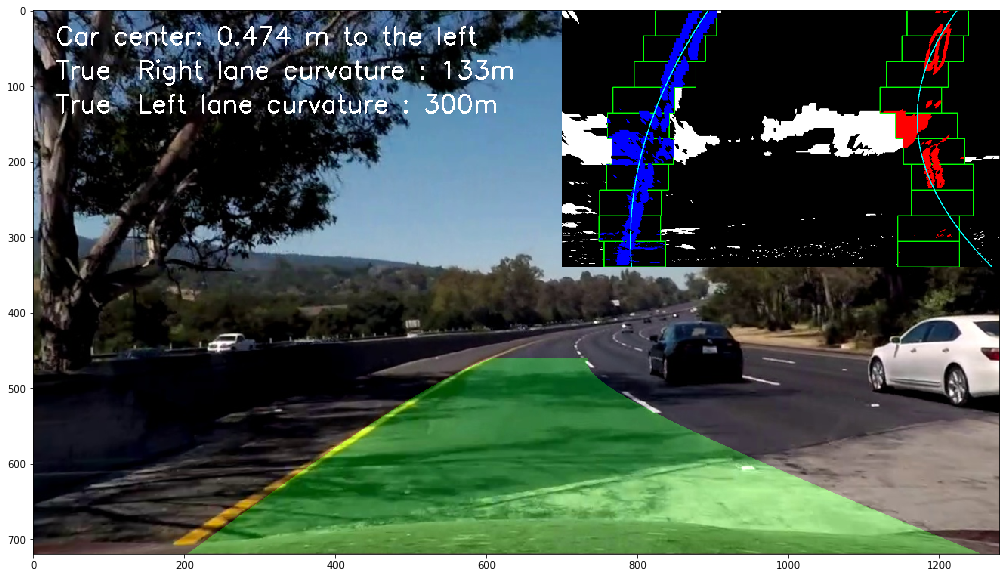

In [211]:
# testing pipeline
rl, ll = Line(), Line()
path1 = 'test_images/color_check2.jpg'
temp = cv2.imread(path1)
ans = pipeline(temp)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(ans, cv2.COLOR_RGB2BGR))


In [142]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [212]:
# global variables
bufferSize = 12
ll = Line(bufferSize) # left line
rl = Line(bufferSize) # right line

output_path = 'videos/project.mp4'
video_path = 'videos/project_video.mp4'

clip1 = VideoFileClip(video_path)  #.subclip(32,47)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path, audio=False)

t:   0%|          | 3/1260 [00:00<01:18, 15.95it/s, now=None]

Moviepy - Building video videos/project.mp4.
Moviepy - Writing video videos/project.mp4



Moviepy - Done !
Moviepy - video ready videos/project.mp4
CPU times: user 3min 47s, sys: 26.3 s, total: 4min 13s
Wall time: 2min 10s


In [213]:
# cap= cv2.VideoCapture(video_path)
# i,j=0,1
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
        
#     if i in [588, 1038]:
#         cv2.imwrite('test_images/color_check'+str(j)+'.jpg',frame)
# #         plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#         j+=1
        
#     i+=1

# cap.release()
# cv2.destroyAllWindows()

In [214]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

## More challenging videos


In [215]:
def pipeline_challenge(original_image):
    # get precalculated camera calibration factors
    global C_mtx ,dist_coef 
    global rl, ll
    
    # distortion correction
    origin, undist_c = undistorted(original_image, C_mtx, dist_coef)
    img = np.copy(origin)
    size = img.shape
    
    # thresholded binary image using color space transform, gradient thresholding
    color_threshold = (170,255)
    color_space = 'RGB'
    channels = color_thresholding(undist_c, color_space, color_threshold)
    channels2 = color_thresholding(undist_c, 'Luv', (100, 150))
    channels3 = color_thresholding(undist_c, 'gray', color_threshold)
    
    ch = channels[0] # S - single channel 
    ch2 = channels2[1] # u - single channel 
#     ch3 = channels3[2]
    ch3 = channels3[0]

    sobel_threshold = (20, 100)
    gray = cv2.cvtColor(undist_c, cv2.COLOR_BGR2GRAY)
#     sobelx = sobel_xy(gray, 'x', sobel_threshold)
#     sobely = sobel_xy(gray, 'y', sobel_threshold)
    sobelm = sobel_magnitude(gray, sobel_threshold)
    sobeld = sobel_direction(gray, (0.7,1.3))
    
    binary = np.zeros_like(ch3)
#     binary[((sobelx==1)|(sobely==1))] = 1
    binary[(ch2==1)|((ch3==1))|((sobelm==1)&(sobeld==1))] = 1
    
    # set region of interest - ROI
    top, bot = 500, 720
    lt, lb = 590, 240 
    rt, rb = 760, 1050
    c1 = 200
#     top, bot = 500, 720
#     lt, lb = 590, 150
#     rt, rb = 740, 1000
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[c1, 0], [size[1]-c1, 0], [size[1]-c1, size[0]], [c1, size[0]]])

    # perspective transform - warped binary
    top_down_, per_M, Minv = perspective_transform(binary, src, dst)
 
    #lane searching
    good_fit = lane_finding(top_down_)
    
    # determine the curvature of the lane and vehicle position wrt center
    ll.radius_of_curvature, rl.radius_of_curvature = curvature(ll.yp, ll.best_fit, rl.best_fit)
    offset = get_offset(size)
    
    # unwarped and draw the lane
    result = visualize(size, top_down_, undist_c, offset, good_fit, Minv)
    return result


In [217]:
def pipeline_challenge2(original_image):
    # get precalculated camera calibration factors
    global C_mtx ,dist_coef 
    global rl, ll
    
    # distortion correction
    origin, undist_c = undistorted(original_image, C_mtx, dist_coef)
    img = np.copy(origin)
    size = img.shape
    
    # thresholded binary image using color space transform, gradient thresholding
    color_threshold = (170,255)
    color_space = 'RGB'
    channels = color_thresholding(undist_c, color_space, color_threshold)
    channels2 = color_thresholding(undist_c, 'Luv', (100, 150))
    
    ch = channels[0] # S - single channel 
    ch2 = channels2[1] # u - single channel 
    
    binary = np.zeros_like(ch)
    binary[((ch==1)|(ch2==1))] = 1

    # set region of interest - ROI
    top, bot = 500, 720
    lt, lb = 500, 160
    rt, rb = 760, 1050
    c1 = 200
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[c1, 0], [size[1]-c1, 0], [size[1]-c1, size[0]], [c1, size[0]]])

    # perspective transform - warped binary
    top_down_, per_M, Minv = perspective_transform(binary, src, dst)
 
    #lane searching
    good_fit = lane_finding(top_down_)
    
    # determine the curvature of the lane and vehicle position wrt center
    ll.radius_of_curvature, rl.radius_of_curvature = curvature(ll.yp, ll.best_fit, rl.best_fit)
    offset = get_offset(size)
    
    # unwarped and draw the lane
    result = visualize(size, top_down_, undist_c, offset, good_fit, Minv)
    return result



In [218]:
# Get single frame for debugging, test image first
# cap= cv2.VideoCapture(video_path1)
# i,j=0,1
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
        
#     if i in [2, 50, 100, 150, 190, 230, 400]:
#         cv2.imwrite('test_images/challenge'+str(j)+'.jpg',frame)
#         j+=1
        
#     i+=1

# cap.release()
# cv2.destroyAllWindows()


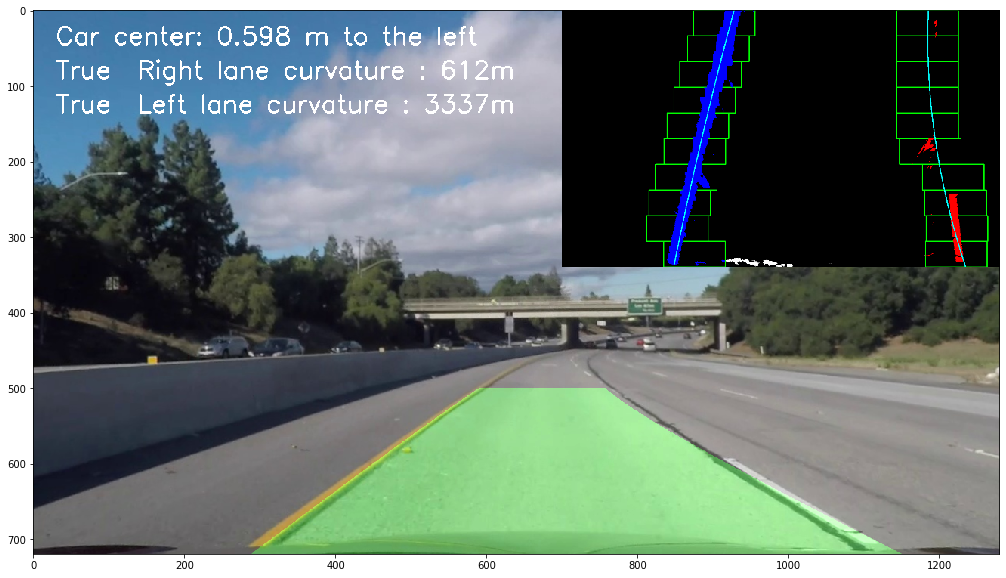

In [219]:
# more challenging video
ll = Line(15) # left line
rl = Line(15) # right line

p1 = 'test_images/challenge1.jpg' 
p2 = cv2.imread(p1)
ans = pipeline_challenge2(p2)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(ans, cv2.COLOR_BGR2RGB))

In [141]:
output_path1 = 'videos/challenge1_wrong.mp4'
video_path1 = 'videos/challenge_video.mp4'

ll = Line(15) # left line
rl = Line(15) # right line

clip1 = VideoFileClip(video_path1) #.subclip(0,14)
white_clip = clip1.fl_image(pipeline_challenge2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path1, audio=False)

t:   1%|          | 3/485 [00:00<00:23, 20.50it/s, now=None]

left window stacking
right window stacking
Moviepy - Building video videos/challenge1_wrong.mp4.
Moviepy - Writing video videos/challenge1_wrong.mp4




t:  26%|██▌       | 125/485 [00:11<00:36,  9.88it/s, now=None]

left window stacking



t:  95%|█████████▍| 459/485 [00:50<00:02, 11.55it/s, now=None]


t:  96%|█████████▌| 465/485 [00:50<00:01, 10.70it/s, now=None]

left window stacking
right window stacking
left window stacking



t:  96%|█████████▋| 468/485 [00:51<00:02,  7.76it/s, now=None]

left window stacking
right window stacking
Warning!
left window stacking
right window stacking



t:  97%|█████████▋| 469/485 [00:51<00:02,  7.34it/s, now=None]

Warning!
left window stacking
right window stacking



t:  97%|█████████▋| 471/485 [00:51<00:02,  6.69it/s, now=None]

left window stacking
right window stacking
left window stacking
right window stacking



t:  98%|█████████▊| 475/485 [00:52<00:01,  6.85it/s, now=None]

left window stacking
right window stacking
no left detection
15 15
Warning!
left window stacking
right window stacking
no left detection
15 15



t:  98%|█████████▊| 476/485 [00:52<00:01,  6.50it/s, now=None]

Warning!
left window stacking
no left detection
15 15
Warning!



t:  98%|█████████▊| 477/485 [00:52<00:01,  4.91it/s, now=None]

left window stacking
right window stacking
no left detection
15 15
Warning!



t:  99%|█████████▉| 479/485 [00:52<00:01,  5.33it/s, now=None]

left window stacking
no left detection
15 15
Warning!
left window stacking
right window stacking
no left detection
15 15



t:  99%|█████████▉| 480/485 [00:53<00:00,  5.59it/s, now=None]

Warning!
left window stacking
right window stacking
no left detection
15 15



t: 100%|██████████| 485/485 [00:53<00:00,  6.14it/s, now=None]

left window stacking
right window stacking


left window stacking
right window stacking


t:  51%|█████     | 607/1199 [1:38:44<00:59,  9.92it/s, now=None]

Moviepy - Done !
Moviepy - video ready videos/challenge1_wrong.mp4
CPU times: user 1min 22s, sys: 6.67 s, total: 1min 29s
Wall time: 55.8 s


In [142]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path1))

In [143]:
# more challenging video
ll = Line(15) # left line
rl = Line(15) # right line

output_path2 = 'videos/challenge2.mp4'
video_path2 = 'videos/harder_challenge_video.mp4'

clip1 = VideoFileClip(video_path2)
white_clip = clip1.fl_image(pipeline_challenge) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path2, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/challenge2.mp4.
Moviepy - Writing video videos/challenge2.mp4




t:  21%|██        | 246/1199 [00:56<03:51,  4.12it/s, now=None]


t:  41%|████      | 490/1199 [01:48<02:17,  5.16it/s, now=None]


t:  59%|█████▉    | 713/1199 [02:42<01:56,  4.18it/s, now=None]

left window stacking



t:  80%|███████▉  | 957/1199 [03:38<00:52,  4.61it/s, now=None]


t:  94%|█████████▍| 1131/1199 [04:13<00:13,  5.10it/s, now=None]

right window stacking



t:  94%|█████████▍| 1133/1199 [04:13<00:15,  4.33it/s, now=None]

right window stacking



t:  51%|█████     | 607/1199 [1:48:51<00:59,  9.92it/s, now=None][A

Moviepy - Done !
Moviepy - video ready videos/challenge2.mp4
CPU times: user 6min, sys: 46.5 s, total: 6min 47s
Wall time: 4min 28s


In [144]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path2))